In [1]:
import sys
import os
import cv2
import numpy as np
import pandas as pd
from skimage.io import imshow
from skimage.filters import threshold_mean
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
if "C:\\Program Files\\ASAP 1.9\\bin" not in sys.path:
    sys.path.append("C:\\Program Files\\ASAP 1.9\\bin")

In [3]:
import multiresolutionimageinterface as mir

In [6]:
# conda install -c sdvillal openslide
import openslide

## Generate mask from input pathology image

In [4]:
# reader = mir.MultiResolutionImageReader()
# mr_image = reader.open('images/50.tif')
# annotation_list = mir.AnnotationList()
# xml_repository = mir.XmlRepository(annotation_list)
# xml_repository.setSource('annotation/50.xml')
# xml_repository.load()
# annotation_mask = mir.AnnotationToMask()
# output_path = '50.tif'
# annotation_mask.convert(annotation_list, output_path, mr_image.getDimensions(), mr_image.getSpacing())

# -------------------------------------------------------------------
# Get pathology slide dimension

In [9]:
slide_path='images1/1.tif'
truth_path='masks/1.tif'

slide = openslide.open_slide(slide_path)
truth = openslide.open_slide(truth_path)

print ("Original Slide dimensions %dx%d" % slide.dimensions)
print ("Original Truth dimensions %dx%d" % truth.dimensions)

Original Slide dimensions 89262x208796
Original Truth dimensions 89262x208796


# -------------------------------------------------------------------
# Display Slide

In [10]:
_READER=mir.MultiResolutionImageReader()

def get_thumbnail(slide_path, zoom=4):
    slide = _READER.open(slide_path)
    slide_shape = slide.getDimensions()
    thumbnail = slide.getUCharPatch(
        0, 0, slide_shape[0] // 2**zoom, slide_shape[1] // 2**zoom, zoom
    )
    slide.close()
    return (thumbnail, slide_shape)

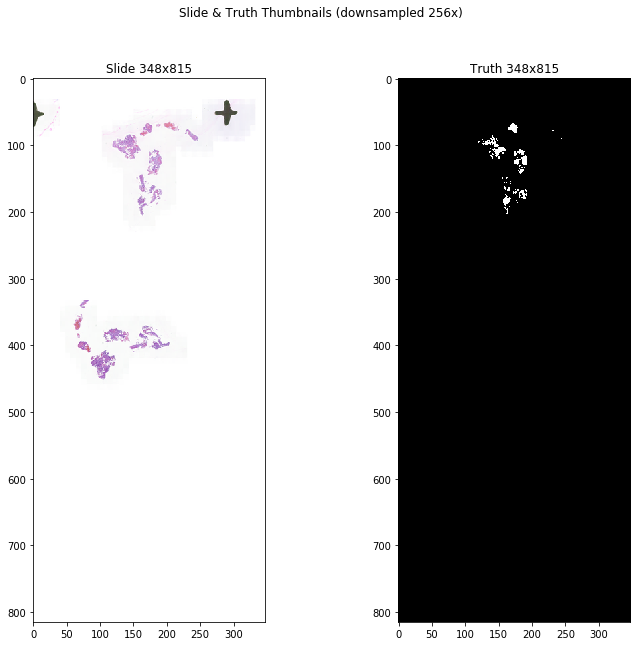

In [12]:
thumbnail = slide.get_thumbnail((slide.dimensions[0] / 256, slide.dimensions[1] / 256))
thumbnail_truth=Image.fromarray(np.array(truth.get_thumbnail((truth.dimensions[0] / 256, truth.dimensions[1] / 256)) )[:,:,0]*255)

f, axes = plt.subplots(1, 2, figsize=(12, 10));
ax = axes.ravel()
ax[0].imshow(thumbnail);
ax[0].set_title('Slide %dx%d' % thumbnail.size)
ax[1].imshow(thumbnail_truth.convert('L'), cmap='gray');
ax[1].set_title('Truth %dx%d' % thumbnail_truth.size)
f.suptitle('Slide & Truth Thumbnails (downsampled 256x)');

# -------------------------------------------------------------------
# Histogram of pixel intensity

In [15]:
from skimage.filters import threshold_otsu

img = np.array(thumbnail.convert('L'))
thresh = threshold_otsu(img)
binary = img > thresh

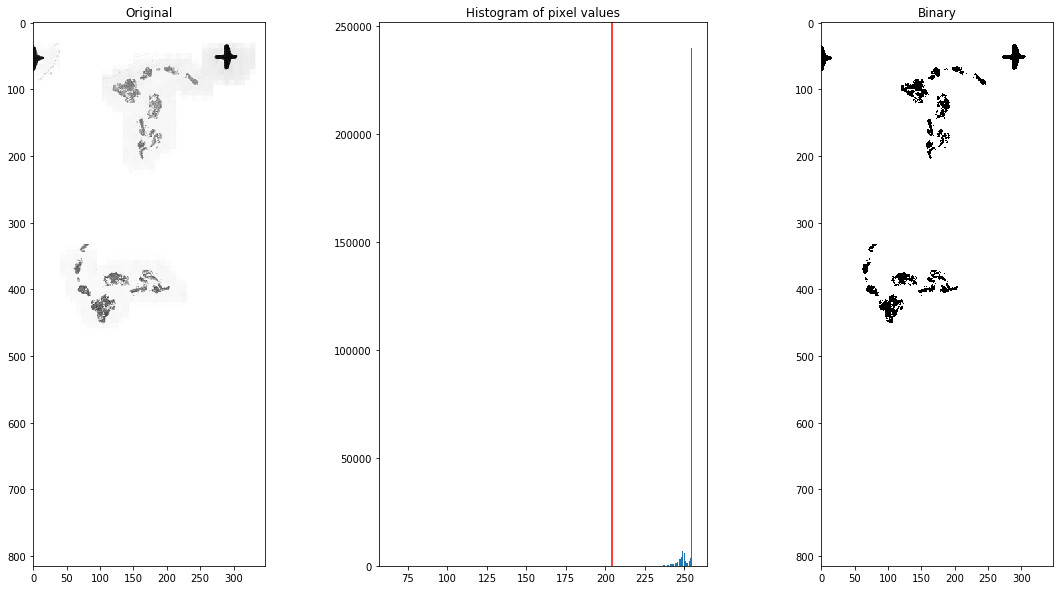

In [16]:
f, axes = plt.subplots(1, 3, figsize=(20, 10));
ax = axes.ravel();
ax[0].imshow(img, cmap='gray');
ax[0].set_title('Original');
ax[1].hist(img.ravel(), bins=256);
ax[1].set_title('Histogram of pixel values');
ax[1].axvline(thresh, color='r');
ax[2].imshow(binary, cmap='gray');
ax[2].set_title('Binary');

# -------------------------------------------------------------------
# Small Patchs of Slide

In [27]:
from openslide.deepzoom import DeepZoomGenerator 

tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)
tiles_truth = DeepZoomGenerator(truth, tile_size=256, overlap=0, limit_bounds=False)

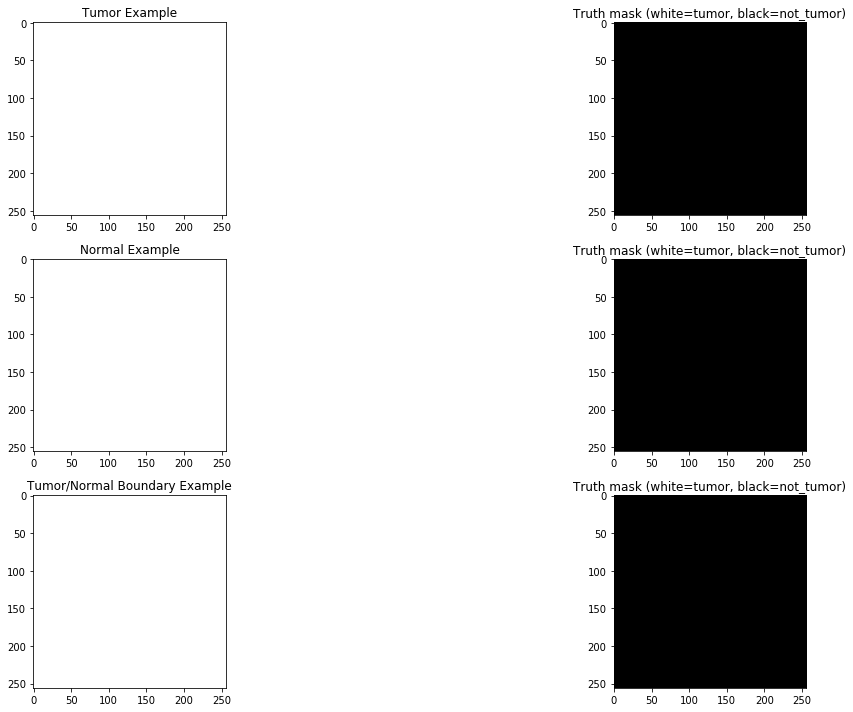

In [28]:
f, axes = plt.subplots(3, 2, figsize=(20, 10))
axes[0, 0].imshow(tiles.get_tile(tiles.level_count-1, (100, 280)));
axes[0, 0].set_title('Tumor Example');
axes[0, 1].imshow(Image.fromarray(np.array(tiles_truth.get_tile(tiles_truth.level_count-1, (100, 280)))[:,:,0]*255).convert('L'));
axes[0, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

axes[1, 0].imshow(tiles.get_tile(tiles.level_count-1, (150, 300)));
axes[1, 0].set_title('Normal Example');
axes[1, 1].imshow(Image.fromarray(np.array(tiles_truth.get_tile(tiles_truth.level_count-1, (200, 300)))[:,:,0]*255).convert('L'));
axes[1, 1].set_title('Truth mask (white=tumor, black=not_tumor)')

axes[2, 0].imshow(tiles.get_tile(tiles.level_count-1, (240, 200)));
axes[2, 0].set_title('Tumor/Normal Boundary Example');
axes[2, 1].imshow(tiles_truth.get_tile(tiles_truth.level_count-1, (240, 200)));
axes[2, 1].set_title('Truth mask (white=tumor, black=not_tumor)');
plt.tight_layout();

# -------------------------------------------------------------------

In [30]:
def get_gray_from_rgb(rgb_image):
    if type(rgb_image) is not np.ndarray:
        rgb_image=np.array(rgb_image)
    return cv2.cvtColor(rgb_image, cv2.COLOR_BGR2GRAY)


def get_external_contours_from_grayscale_image(grayscale_image):
    image, contours, hierarchy = cv2.findContours(grayscale_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return contours


def get_bbox_from_contours(contours):
    return [cv2.boundingRect(c) for c in contours]


slide_path='images1/1.tif'
slide = openslide.open_slide(slide_path)
thumbnail = slide.get_thumbnail((slide.dimensions[0] / 256, slide.dimensions[1] / 256))
thumbnail = cv2.cvtColor(np.array(thumbnail), cv2.COLOR_RGB2BGR) # читаем
gray = cv2.cvtColor(thumbnail, cv2.COLOR_BGR2GRAY) # rgb to gray
gray = cv2.GaussianBlur(gray, (3, 3), 0) # гаусоовый шум
edged = cv2.Canny(gray, 10, 250) # определяем края
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)) 
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
image, contours, hierarchy = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [31]:
for cont in contours:
    peri = cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, 0.001 * peri, True)
    cv2.drawContours(thumbnail, [approx], -1, (0, 255, 0), 2)

In [32]:
# cv2.imshow("Output", thumbnail)
# cv2.waitKey(0)

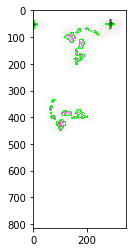

In [33]:
plt.imshow(thumbnail)

In [34]:
len(contours)

15

# -------------------------------------------------------------------

In [35]:
def normalize(image):    
    if type(image) is not np.ndarray:
        image=np.array(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, *ab = cv2.split(image)
    clahe = cv2.createCLAHE(2., (8, 8))
    l = clahe.apply(l)
    image = cv2.merge([l, *ab])
    image = cv2.cvtColor(image, cv2.COLOR_LAB2BGR)
    return image

In [37]:
slide=_READER.open('images1/1.tif')
w,h=slide.getDimensions()
thumbnail=slide.getUCharPatch(0, 0, w//256, h//256, 8)
slide.close()
thumbnail = Image.fromarray(thumbnail).convert('RGB')
thumbnail=normalize(thumbnail)

gray = cv2.cvtColor(thumbnail, cv2.COLOR_BGR2GRAY) # rgb to gray
gray = cv2.GaussianBlur(gray, (3, 3), 0) # гаусоовый шум
edged = cv2.Canny(gray, 10, 250) # определяем края
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5)) 
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)
_, contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
for cont in contours:
    peri = cv2.arcLength(cont, True)
    approx = cv2.approxPolyDP(cont, 0.001 * peri, True)
    cv2.drawContours(thumbnail, [approx], -1, (0, 255, 0), 2)

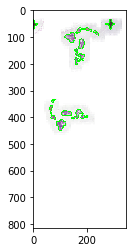

In [38]:
plt.imshow(thumbnail)

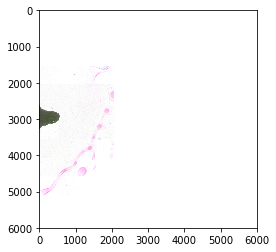

In [40]:
slide = openslide.OpenSlide('images1/1.tif')

tile = np.array(slide.read_region((2000,2000),2, (6000,6000)))
plt.figure()
plt.imshow(tile)
plt.show()